In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from numpy import pi as npi
from scipy.stats import multivariate_normal
from dynesty import NestedSampler
from dynesty.utils import resample_equal
import corner
from scipy.stats import norm

/home/nsb2655/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Text(0, 0.5, '$h(t)$')

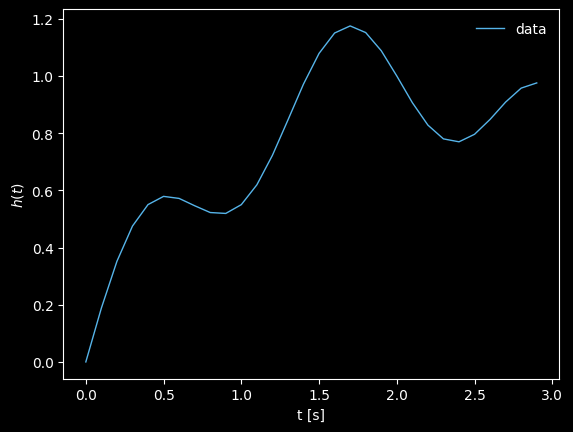

In [3]:
A0_inj, f0_inj = 0.2, 0.75
noise_sigma = 1.0
times = np.arange(0, 3, 0.1)
noise_sigma = 0.1


injection = A0_inj * np.sin(2*npi*f0_inj*times) + times - 0.25*times**2

# lets make data noiseless for convinence 
data = injection #+ noise_sigma*np.random.normal(size=times.size)

## Lets make some plots of out data to check that it looks ok
ax = plt.gca()

# time domain plot
ax.plot(times, data, label='data', color='#56B4E9', lw=1.0)
#ax.plot(times, injection, label='simulated signal', color='#D55E00', lw=1.0)
ax.legend(frameon=False)
ax.set_xlabel('t [s]')
ax.set_ylabel('$h(t)$')

In [1]:
class nested_sample_autoreg():

    def __init__(self, data, times, noise_sigma):
        self.data = data
        self.times = times
        self.delt = times[1] - times[0]
        self.noise_sigma = noise_sigma
        self.npar = 3 # only b, tau and sigma

    def AR1(self, theta):

        min_vals = np.array([-6, 0.001, 0.01])
        max_vals = np.array([6, 20, 10])
        
        theta[0:3] = (max_vals - min_vals) * theta[0:3] + min_vals

    
        return theta
    
    

    def loglike(self, theta,):


        
        b, tau, sigma = theta[0], theta[1], theta[2]
        
        ## these are the values at the nodes
        psi_i = self.data

        
        ## the mean-subtracted values i.e. psi*
        psi_star = psi_i - b*tau
        
        
        ## initializing an array of autoregressive predictions
        psi_hat = np.zeros(psi_i.size)
        
    
        # the first element we leave zero
        psi_hat[1:] = np.exp(-self.delt / tau) * (psi_star[0:-1]) 
        
        var = 0.5*tau*sigma**2 * (1 - np.exp(-2*self.delt / tau))
        
        # probability for the CAR(1) model. 
        log_prob = - 0.5 * (psi_star - psi_hat)**2 / var  - 0.5 * np.log(2 * np.pi * var)
        
        # no loglikelihood term anymore
        # log-likelihood for the data
        #loglike = -0.5 * (self.data - psi_i)**2 / self.noise_sigma**2

        return log_prob.sum()



### Unmdoeled fitting. 

We will use a nested sampler called dynesty to sample this high dimensional space. Nested samplers usually produce random samples from a uniform N-dimensional unit hypercube, where N is the number of independent parameters. 

$$\theta_i \sim U[0, 1) \qquad i \in [1, N]$$

We need to provide a nested sampler two functions to work. 

1. A prior transformation function to transform the unit hypercube draws into draws from out actual prior. 

In the example below the function function `AR1` serves as the prior transformation function. It provides a uniform prior for $b, \tau and \sigma$. It also provides a uniform prior for each $\psi_i \sim U[-6, 6]$

2. A likelihood function to calculate $p(d | \theta)$ for our draws. 


Remember that for a $CAR(1)$ process

$$p\left (\psi(t) | \psi(t'), \tau, \sigma, b \right) = \frac{1}{\sqrt{2 \pi \Omega(t)}} \exp \left [ - \frac{\left( \psi^*(t) - \hat{\psi} (t) \right)^2}{2 \Omega^2(t)}\right]$$


where $$\hat{\psi}(t) \equiv E \left (\psi(t) | \psi (t') \right) - b \tau  = e^{-\Delta t / \tau} \left (\psi(t') - b \tau \right )$$


and $$\Omega(t) = \frac{\tau \sigma^2}{2} \left(1 - e^{-2 \Delta t / \tau} \right)$$


$$p\left ( \psi(t_1), \psi(t_2), ..., \psi(t_n)  |\tau, \sigma, b \right) = \prod_i^n \frac{1}{\sqrt{2 \pi \Omega(t)}} \exp \left [ - \frac{\left( \psi^*(t_i) - \hat{\psi} (t_i) \right)^2}{2 \Omega^2(t_i)}\right]$$

Since this is a forecasting excercise, let's make our lives easier and assume that there is no noise

In [72]:
tcut = 1.5

ar_obj = nested_sample_autoreg(data[times <=tcut], times[times <= tcut], noise_sigma)

engine = NestedSampler(ar_obj.loglike, 
                       ar_obj.AR1, ar_obj.npar,
                       bound='multi', nlive=250)
engine.run_nested(dlogz=0.1,print_progress=True )

3189it [00:05, 554.40it/s, +250 | bound: 36 | nc: 1 | ncall: 22306 | eff(%): 15.592 | loglstar:   -inf < 14.677 <    inf | logz:  4.285 +/-  0.189 | dlogz:  0.000 >  0.100]


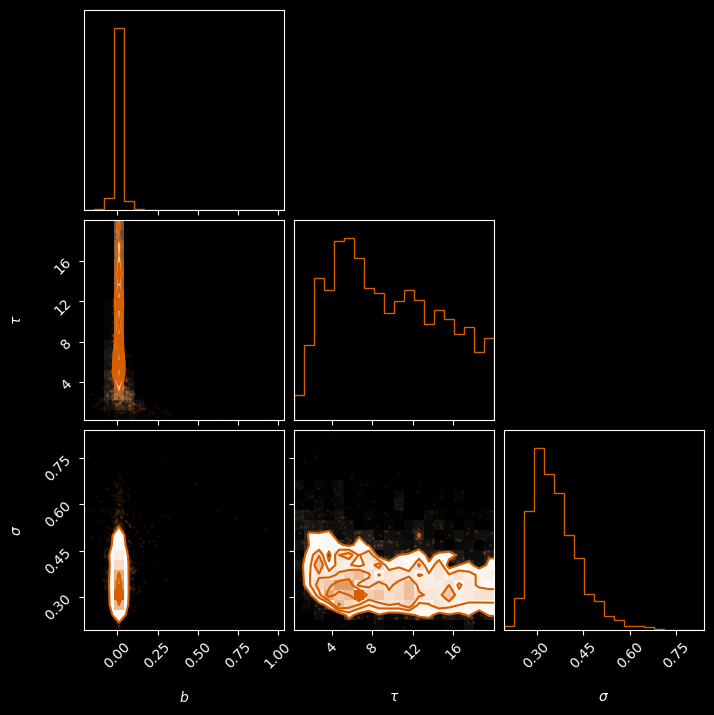

In [73]:
res = engine.results
weights = np.exp(res['logwt'] - res['logz'][-1])
weights[-1] = 1 - np.sum(weights[0:-1])

post_samples = resample_equal(res.samples, weights)
fig = corner.corner(
    post_samples[:, 0:3], 
    labels=['$b$', '$\\tau$', '$\\sigma$'], color='#D55E00')

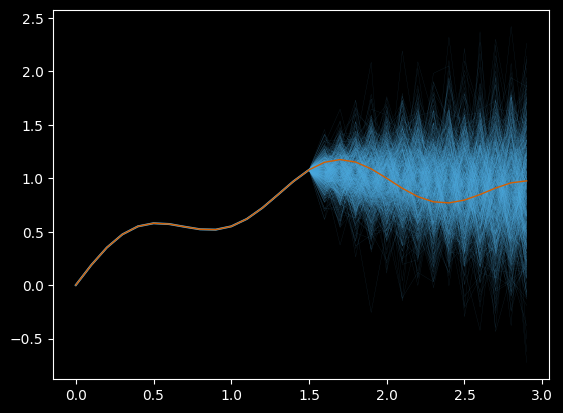

In [74]:
plt.plot(times[times <= tcut], data[times <=tcut], color='#56B4E9')


for ii in range(1000):
    
    b, tau, sigma = post_samples[ii, 0], post_samples[ii, 1], post_samples[ii, 2]
    
    delt = times[times >= tcut] - tcut
    
    expectation = np.exp( - delt/tau) * (data[times <=tcut][-1] - b*tau) + b * tau
    
    variance = 0.5*tau * sigma**2 * (1 - np.exp( - 2*delt/tau))
    
    forecast = np.random.default_rng().normal(expectation, np.sqrt(variance))
    
    plt.plot(times[times >=tcut], forecast, color='#56B4E9', alpha=0.2, lw=0.2)

plt.plot(times, data, label='data', color='#D55E00', lw=1.0)

In [75]:
post_samples.shape

(3439, 3)